## Goal:

Search for anomalies in the time series of burn severity with unsupervised learning (no labeled data).

### Load Packages and Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
from pyemma import msm
%matplotlib inline

In [2]:
os.chdir("E:/Trends")
severity = pd.read_csv('burn_severity_clear_data.csv')

In [4]:
#set number of digits
pd.set_option('display.float_format', lambda x: '%.3f' % x)
severity['RdNBR'].describe()

count   3270935.000
mean          0.609
std           0.601
min         -41.976
25%           0.247
50%           0.578
75%           0.987
max          36.305
Name: RdNBR, dtype: float64

In [12]:
df = severity[['Year', 'RdNBR', 'Veg']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270935 entries, 0 to 3270934
Data columns (total 3 columns):
Year     int64
RdNBR    float64
Veg      int64
dtypes: float64(1), int64(2)
memory usage: 74.9 MB


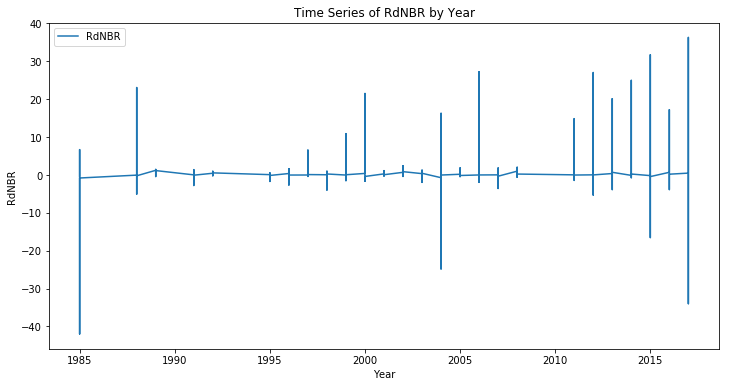

In [13]:
# plot the data
df.plot(x='Year', y='RdNBR', figsize=(12,6))
plt.xlabel('Year')
plt.ylabel('RdNBR')
plt.title('Time Series of RdNBR by Year');

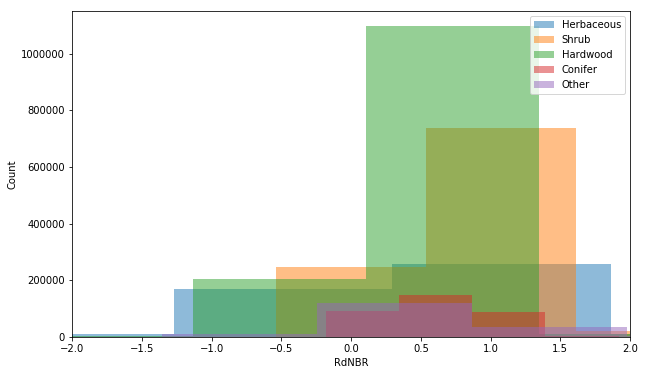

In [19]:
a = df.loc[df['Veg'] == 60, 'RdNBR'] #Herbaceous
b = df.loc[df['Veg'] == 70, 'RdNBR'] #Shrub
#use | and & instead of 'or' and 'and' in here
c = df.loc[((df['Veg'] == 51) | (df['Veg'] == 52)), 'RdNBR'] #Hardwood
d = df.loc[((df['Veg'] == 31) | (df['Veg'] == 32)), 'RdNBR'] #Conifer
e = df.loc[((df['Veg'] != 31) & (df['Veg'] != 32) & (df['Veg'] != 52) & (df['Veg'] != 51) & (df['Veg'] != 70) & (df['Veg'] != 60)), 'RdNBR'] #Other
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Herbaceous')
plt.hist(b, bins = 50, alpha=0.5, label='Shrub')
plt.hist(c, bins = 50, alpha=0.5, label='Hardwood')
plt.hist(d, bins = 50, alpha=0.5, label='Conifer')
plt.hist(e, bins = 50, alpha=0.5, label='Other')
#plt.xlim(-2, 2)
plt.legend(loc='upper right')
plt.xlabel('RdNBR')
plt.ylabel('Count')
plt.show();

## Clustering-Based Anomaly Detection

### k-means algorithm

k-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

Before starting k-means clustering, use elbow method to determine the optimal number of clusters
when the graph levels off after n clusters, it implies that addition of more clusters do not explain much more of the variance in our relevant variable

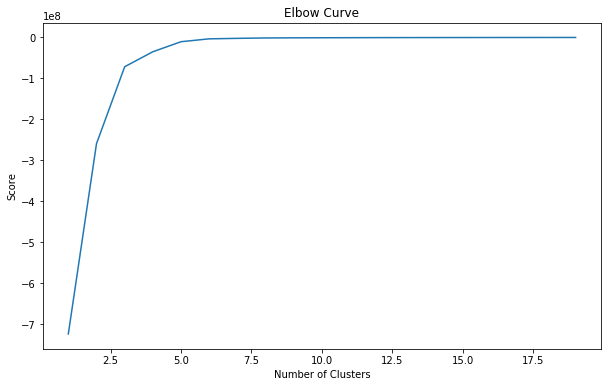

In [20]:
data = df[['RdNBR', 'Veg']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 5 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.

we set n_clusters=5, and upon generating the k-means output use the data to plot the 3D clusters:

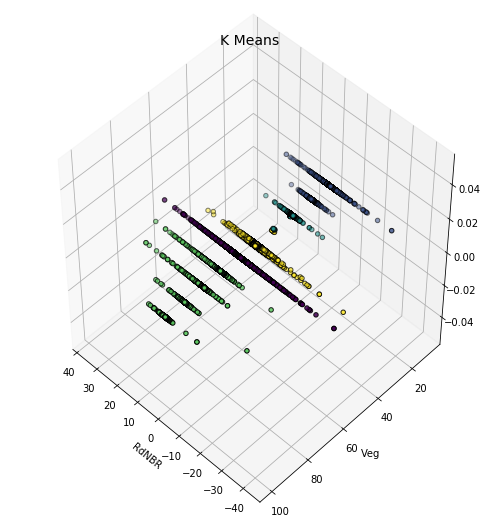

In [21]:
X = df[['RdNBR', 'Veg']]
#When we reset the index, the old index is added as a column, and a new sequential index is used
#Use the drop command to avoid adding the old index as the new column
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5) #define the number of clusters based on elbow curve
#Compute k-means clustering
km.fit(X)
#Predict the closest cluster each sample in X belongs to
km.predict(X)
#Alternatively, use fit_predict, which is a convenience method; equivalent to calling fit(X) followed by predict(X)
#labels is an attribute: Labels of each point
labels = km.labels_
#Other attributes: 
#cluster_centers_ (Coordinates of cluster centers); n_iter_ (Number of iterations run)
#inertia_ (Sum of squared distances of samples to their closest cluster center)
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
#iloc is index based (use integer/boolean, iloc.[a,b] exclude b iloc.[True, False, True] returns the first and third rows) 
#loc is label based (.loc[,'lab'] include the 'lab') 
ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels.astype(np.float), edgecolor="k")
#ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
#          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("RdNBR")
ax.set_ylabel("Veg")
#ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

### PCA

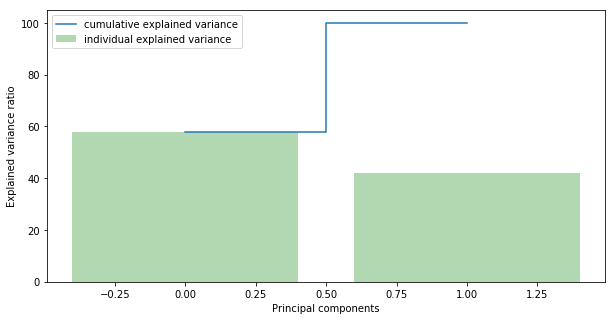

In [22]:
data = df[['RdNBR', 'Veg']]
X = data.values
X_std = StandardScaler().fit_transform(X)
#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [23]:
# Take useful feature and standardize them
data = df[['RdNBR', 'Veg']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [28]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[4].predict(data) #read the kmeans when n_clusters=5
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

3    1311435
0     985246
2     515713
1     455102
4       3439
Name: cluster, dtype: int64

In [31]:
df.head()

,Year,RdNBR,Veg,cluster,principal_feature1,principal_feature2
0,1985,-0.296,60,2,0.774,1.411
1,1985,-0.296,60,2,0.774,1.411
2,1985,-0.276,60,2,0.752,1.386
3,1985,-0.076,60,2,0.534,1.129
4,1985,-0.257,60,2,0.731,1.361


### Clustering Approach

The underline assumption in the clustering approach is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

In [32]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #FutureWarning: set_value is deprecated and will be removed in a future release. 
        #Please use .at[] or .iat[] accessors instead
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[4]) #Change to the corresponding n-cluster
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


MemoryError: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [ ]:
df.anomaly1.value_counts()

In [ ]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

Visualization of anomaly with re-partition

In [ ]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();